In [14]:
import os
import librosa
import numpy as np
import pandas as pd
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Paths
DATA_DIR = r"C:\Users\gaura\MY Desktop\shl model"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "train")
TEST_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "test")
SUBMISSION_FILE = os.path.join(DATA_DIR, "sample_submission.csv")

In [16]:
import os

def add_wav_extension(folder):
    for fname in os.listdir(folder):
        if not fname.endswith(".wav"):
            old_path = os.path.join(folder, fname)
            new_path = os.path.join(folder, fname + ".wav")
            os.rename(old_path, new_path)

# Set your paths
train_path =r"C:\Users\gaura\MY Desktop\shl model\audios\train"
test_path = r"C:\Users\gaura\MY Desktop\shl model\audios\test"

add_wav_extension(train_path)
add_wav_extension(test_path)

print("✅ Added .wav extension to all audio files.")


✅ Added .wav extension to all audio files.


In [17]:
# Load metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Clean filename entries
train_df["filename"] = train_df["filename"].astype(str).str.strip()
test_df["filename"] = test_df["filename"].astype(str).str.strip()

# Add full paths
train_df["full_path"] = train_df["filename"].apply(lambda x: os.path.join(TRAIN_AUDIO_DIR, x))
test_df["full_path"] = test_df["filename"].apply(lambda x: os.path.join(TEST_AUDIO_DIR, x))

# Debug: check file existence
train_df["file_exists"] = train_df["full_path"].apply(os.path.exists)
test_df["file_exists"] = test_df["full_path"].apply(os.path.exists)

# Print info
print(f"Train CSV: {len(train_df)} entries")
print(f"Train audio files found: {train_df['file_exists'].sum()}")
print(f"Test CSV: {len(test_df)} entries")
print(f"Test audio files found: {test_df['file_exists'].sum()}")

# Keep only existing files
train_df = train_df[train_df["file_exists"]].reset_index(drop=True)
test_df = test_df[test_df["file_exists"]].reset_index(drop=True)


Train CSV: 444 entries
Train audio files found: 444
Test CSV: 204 entries
Test audio files found: 204


In [18]:
# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [19]:
# Feature extractor
def extract_features(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    waveform, sr = librosa.load(file_path, sr=16000)
    input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        features = model(input_values).last_hidden_state.mean(dim=1).squeeze().numpy()
    return features

In [20]:

# Filter classes with at least 2 samples
label_counts = train_df["label"].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df = train_df[train_df["label"].isin(valid_labels)].reset_index(drop=True)

In [21]:
# Encode labels
train_df["full_path"] = train_df["filename"].apply(lambda x: os.path.join(TRAIN_AUDIO_DIR, x))
train_df = train_df[train_df["full_path"].apply(os.path.exists)].reset_index(drop=True)
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])

In [22]:
# Extract features
X_train, y_train = [], []
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    features = extract_features(row["full_path"])
    if features is not None:
        X_train.append(features)
        y_train.append(row["label_encoded"])

X = np.array(X_train)
y = np.array(y_train)

100%|██████████| 444/444 [2:47:00<00:00, 22.57s/it]    


In [23]:
# Save features and labels to disk
np.save(os.path.join(DATA_DIR, "X_train.npy"), X)
np.save(os.path.join(DATA_DIR, "y_train.npy"), y)
print("✅ Features and labels saved to disk.")





✅ Features and labels saved to disk.


In [24]:

# Balance dataset
df_features = pd.DataFrame(X)
df_features["label"] = y
max_class_size = df_features["label"].value_counts().max()
balanced_dfs = [resample(df_features[df_features["label"] == lbl], replace=True,
                         n_samples=max_class_size, random_state=42) for lbl in df_features["label"].unique()]
df_balanced = pd.concat(balanced_dfs)
X_bal = df_balanced.drop("label", axis=1).values
y_bal = df_balanced["label"].values



In [25]:
# Split dataset
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)



In [26]:
# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_test_split)



In [27]:
# Evaluation
unique_test_labels = np.unique(y_test_split)
label_names = label_encoder.inverse_transform(unique_test_labels)
print(classification_report(y_test_split, y_pred, target_names=label_names.astype(str)))



              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30
         1.5       1.00      1.00      1.00        30
         2.0       1.00      0.93      0.97        30
         2.5       0.94      1.00      0.97        30
         3.0       0.91      1.00      0.95        30
         3.5       1.00      1.00      1.00        30
         4.0       1.00      0.83      0.91        30
         4.5       0.87      0.90      0.89        30
         5.0       0.84      0.87      0.85        30

    accuracy                           0.95       270
   macro avg       0.95      0.95      0.95       270
weighted avg       0.95      0.95      0.95       270



In [28]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
print(f"\nRMSE on validation set: {rmse:.4f}")

# Pearson Correlation
pearson_corr, _ = pearsonr(y_test_split, y_pred)
print(f"Pearson Correlation on validation set: {pearson_corr:.4f}")




RMSE on validation set: 0.5994
Pearson Correlation on validation set: 0.9730


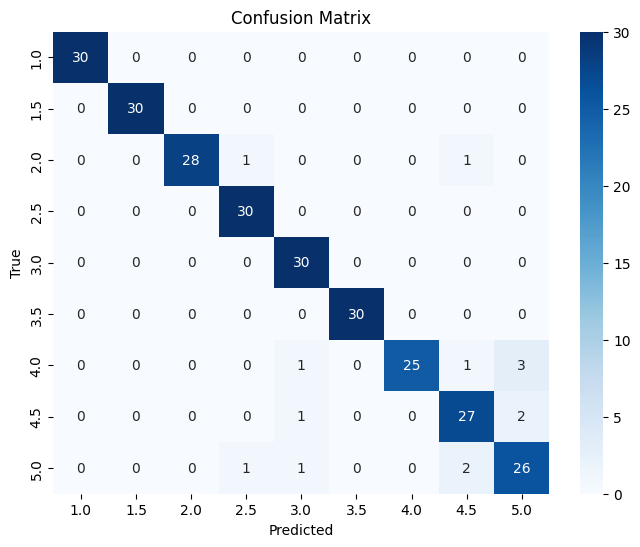

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test_split, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



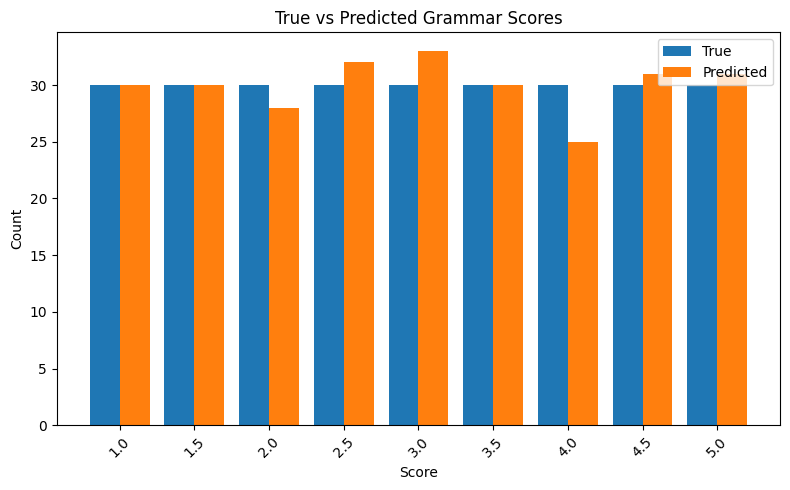

In [30]:
# Histogram
plt.figure(figsize=(8,5))
plt.hist([y_test_split, y_pred], bins=np.arange(0, len(label_names)+1)-0.5, 
         label=['True', 'Predicted'], rwidth=0.8)
plt.xticks(np.arange(len(label_names)), label_names, rotation=45)
plt.legend()
plt.title('True vs Predicted Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [ ]:


# --- FINAL TEST PREDICTION ---
test_df["full_path"] = test_df["filename"].apply(lambda x: os.path.join(TEST_AUDIO_DIR, x))

X_test_final = []
valid_filenames = []
skipped_files = []

for path, filename in tqdm(zip(test_df["full_path"], test_df["filename"]), total=len(test_df), desc="Extracting test features"):
    feat = extract_features(path)
    if feat is not None:
        X_test_final.append(feat)
        valid_filenames.append(filename)
    else:
        skipped_files.append(filename)


print(f"\n✅ Successfully extracted features for {len(valid_filenames)} / {len(test_df)} files.")
if skipped_files:
    print(f"⚠️ Skipped {len(skipped_files)} files (could not load):")
    for f in skipped_files:
        print(f" - {f}")

X_test_final = np.array(X_test_final)

# Predict
test_preds = clf.predict(X_test_final)
decoded_preds = label_encoder.inverse_transform(test_preds)

# Save features and valid filenames
np.save(os.path.join(DATA_DIR, "X_test_final.npy"), X_test_final)
pd.Series(valid_filenames).to_csv(os.path.join(DATA_DIR, "valid_test_filenames.csv"), index=False)

print("✅ Test features and filenames saved.")





Extracting test features: 100%|██████████| 204/204 [58:10<00:00, 17.11s/it]  



✅ Successfully extracted features for 204 / 204 files.
✅ Test features and filenames saved.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gaura\\MY Desktop\\shl model\\sample_submission.csv'

In [34]:
# Create submission
submission_df = pd.read_csv(SUBMISSION_FILE)
submission_df = submission_df[submission_df["filename"].isin(valid_filenames)].reset_index(drop=True)
submission_df["label"] = decoded_preds
submission_df.to_csv("submission.csv", index=False)
print("\n✅ submission.csv created with valid predictions only.")


✅ submission.csv created with valid predictions only.
